In [ ]:
# maintenant si on veux on peux aussi faire des query avec des and statements pour avoir des données plus précises ou des or statements pour avoir des données plus larges
# directment dans la query sql  
# le but c'est de limiter les requettes trop lourde pour ne pas surcharger la mémoire de l'ordinateur
# on peut maintenant programmer des requettes plus précises pour des analyse que le souhaiterais faire
# si toutefois on veux faire des requettes plus lourdes on peux utiliser des librairies comme dask qui permettent de faire des requettes plus lourdes
# ou on peut faire des df concatener c'est à dire par chunk et les concatener pour avoir un df plus grand

In [103]:
# Read the CSV file into a pandas DataFrame
import pandas as pd

# trade data for total hs codes for canada and its partners
# Read the Excel file into a pandas DataFrame
excel_file_path = r"C:\\Users\\Liamt\\Downloads\\TradeData.xlsx"
df_excel = pd.read_excel(excel_file_path)

# Display the first few rows of the DataFrame
df_excel.tail()

,typeCode,freqCode,refPeriodId,refYear,refMonth,period,reporterCode,reporterISO,reporterDesc,flowCode,...,netWgt,isNetWgtEstimated,grossWgt,isGrossWgtEstimated,cifvalue,fobvalue,primaryValue,legacyEstimationFlag,isReported,isAggregate
5026,C,M,20231201,2023,12,202312,124,CAN,Canada,X,...,0.0,True,0,False,NaN,2.453627e+06,2.453627e+06,4,False,True
5027,C,M,20231201,2023,12,202312,124,CAN,Canada,X,...,0.0,True,0,False,NaN,1.177950e+06,1.177950e+06,4,False,True
5028,C,M,20231201,2023,12,202312,124,CAN,Canada,X,...,0.0,True,0,False,NaN,1.628812e+07,1.628812e+07,4,False,True
5029,C,M,20231201,2023,12,202312,124,CAN,Canada,X,...,0.0,False,0,False,NaN,6.353606e+05,6.353606e+05,0,False,True
5030,C,M,20231201,2023,12,202312,124,CAN,Canada,X,...,0.0,True,0,False,NaN,1.368684e+06,1.368684e+06,4,False,True


In [110]:
import json
# Load the JSON data from the file
# with the dict for partner codes with the country name we can easily find the code and then use it to find the data in the database
file_path= "C:\\Users\\Liamt\\OneDrive\\Bureau\\python Wcode_gen\\partner_reporters_dict.json"
# Load the JSON data from the file
with open('partner_reporters_dict.json', 'r') as file:
    try:
        data = json.load(file)
        partner_reporters_dict = data.get("results", [])
    except json.JSONDecodeError:
        print("Error: JSON file is empty or contains invalid JSON data.")
        partner_reporters_dict = []

# Function to search for a country name
def search_country(country_name):
    for entry in partner_reporters_dict:
        # Search in 'text' or 'reporterDesc' fields
        if country_name.lower() in entry.get("text", "").lower() or country_name.lower() in entry.get("reporterDesc", "").lower():
            return entry  # Return the entire dictionary if a match is found
    return None


In [111]:
# Example usage of the search_country_by_name function
country_name = "China"  # Change this to search for a different country
result = search_country(country_name)
if result:
    print(f"Country found: {result}")
    print(f"Country code: {result.get('reporterCode')}")
else:
    print("Country not found")

Country found: {'id': 156, 'text': 'China', 'reporterCode': 156, 'reporterDesc': 'China', 'reporterNote': 'China', 'reporterCodeIsoAlpha2': 'CN', 'reporterCodeIsoAlpha3': 'CHN', 'entryEffectiveDate': '1900-01-01T00:00:00', 'isGroup': False}
Country code: 156


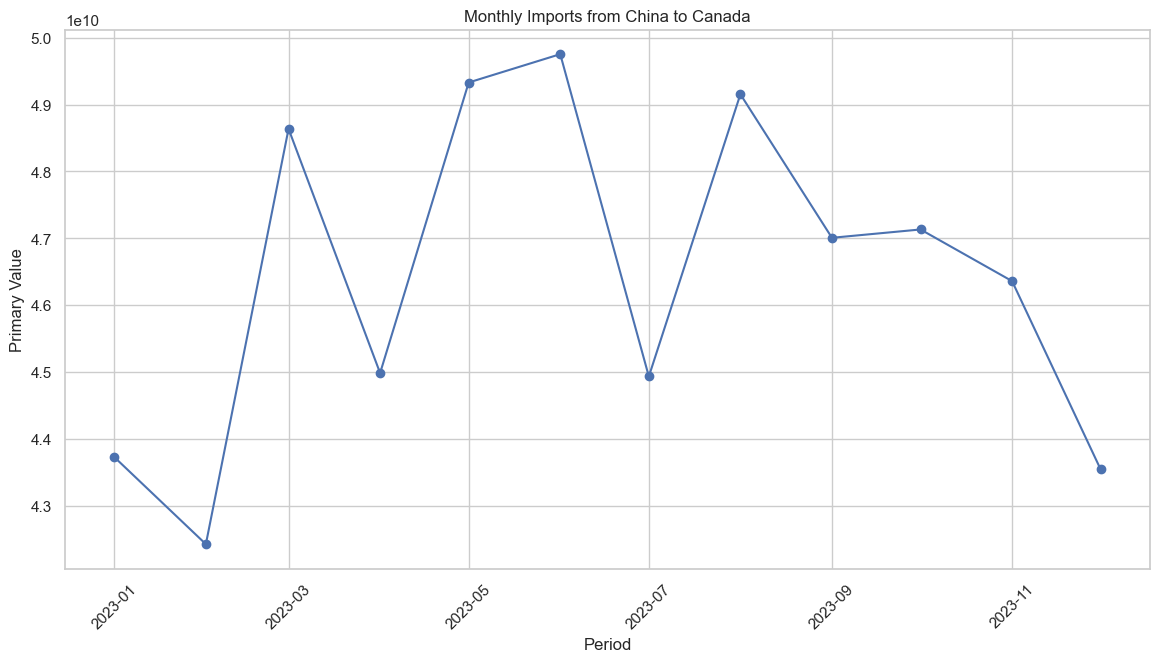

In [116]:
import matplotlib.pyplot as plt

# Convert the 'period' column to datetime format
df_excel['period'] = pd.to_datetime(df_excel['period'], format='%Y%m')


country_df = df_excel[df_excel['partnerCode'] == 156]
# Group by period and get the primary values
monthly_imports = df_excel.groupby('period')['primaryValue'].first()

# Plot the data
plt.figure(figsize=(14, 7))
plt.plot(monthly_imports.index, monthly_imports.values, marker='o', linestyle='-')
plt.title('Monthly Imports from China to Canada')
plt.xlabel('Period')
plt.ylabel('Primary Value')
plt.xticks(rotation=45)
plt.grid(True)
plt.show()


In [113]:
from countryinfo import CountryInfo
country_name= "China"
country_info = CountryInfo(country_name)

# Print some information about China
print(f"Name: {country_info.name()}")
print(f"Region: {country_info.region()}")
print(f"Subregion: {country_info.subregion()}")
print(f"Coordinates: {country_info.info().get('latlng')}")


Name: china
Region: Asia
Subregion: Eastern Asia
Coordinates: [35, 105]


In [114]:

import folium
from folium.plugins import MarkerCluster

def get_country_coordinates(country_name):
    try:
        # Standardize the country name using pycountry
        country_info = CountryInfo(country_name)
        lat, lon = country_info.info()['latlng']
        return lat, lon
    except KeyError:
        print(f"Coordinates for {country_name} not found in CountryInfo.")
    except Exception as e:
        print(f"An error occurred while processing {country_name}: {e}")
    return None

# Sum the monthly values for each partner country
yearly_imports = df_excel[df_excel['flowCode'] == 'M'].groupby('partnerDesc')['primaryValue'].sum().reset_index()

# Create a base map
m = folium.Map(location=[56.1304, -106.3468], zoom_start=3)

# Add a marker cluster to the map
marker_cluster = MarkerCluster().add_to(m)

# Add markers to the map
for _, row in yearly_imports.iterrows():
    partner_name = row['partnerDesc']
    value = row['primaryValue']
    
    # Get the latitude and longitude of the country
    coordinates = get_country_coordinates(partner_name)
    if coordinates:
        lat, lon = coordinates
        # Add a marker to the map
        folium.Marker(
            location=[lat, lon],
            popup=f"{partner_name}: {value/1e9:.2f} B USD" if value >= 1e9 else f"{partner_name}: {value/1e6:.2f} M USD",
            icon=folium.Icon(color='blue', icon='info-sign')
        ).add_to(marker_cluster)

# Display the map
m


Coordinates for Andorra not found in CountryInfo.
Coordinates for Antarctica not found in CountryInfo.
Coordinates for Bahamas not found in CountryInfo.
Coordinates for Bolivia (Plurinational State of) not found in CountryInfo.
Coordinates for Bonaire not found in CountryInfo.
Coordinates for Bosnia Herzegovina not found in CountryInfo.
Coordinates for Bouvet Island not found in CountryInfo.
Coordinates for Br. Indian Ocean Terr. not found in CountryInfo.
Coordinates for Br. Virgin Isds not found in CountryInfo.
Coordinates for Brunei Darussalam not found in CountryInfo.
Coordinates for Cabo Verde not found in CountryInfo.
Coordinates for Cayman Isds not found in CountryInfo.
Coordinates for Central African Rep. not found in CountryInfo.
Coordinates for China, Hong Kong SAR not found in CountryInfo.
Coordinates for China, Macao SAR not found in CountryInfo.
Coordinates for Christmas Isds not found in CountryInfo.
Coordinates for Cocos Isds not found in CountryInfo.
Coordinates for Cong

In [ ]:
# many coordinates are not found in the country info library so we can use the geopy library to find the coordinates of the countries
# I have yet to find a solution

